In [14]:
## Adopted from https://root.cern/doc/master/df104__HiggsToTwoPhotons_8py.html
import ROOT
from ROOT import TH1D, TF1

In [15]:
## Open the file

filename = "Inv_mass_gghasOneL_DNN_HL.root"

datadir = "./data/"
path = datadir + filename

outputdir = "./output/"

#filename = "Mgg_c4_Zveto_HL.root"
file = ROOT.TFile.Open(path)

In [16]:
## Get histograms
Continuum_Bkg = file.Get("Continuum_Bkg")
GGHH = file.Get("GGHH")
GGH  = file.Get("GGH")
VBFH = file.Get("VBFH")
VH   = file.Get("VH")
ttH  = file.Get("ttH")
tHq  = file.Get("tHq")

# define single H bkg histo
hSH = TH1D("hSH", "Single H Bkg.", 80, 100, 180)
hSH.Add(GGH)
hSH.Add(VBFH)
hSH.Add(VH)
hSH.Add(ttH)
hSH.Add(tHq)

# define full bkg histo
hFB = TH1D("hFB", "Full Bkg.", 80, 100, 180)
hFB.Add(hSH, Continuum_Bkg)

# define signal + full bkg histo
hSB = TH1D("hSB", "Signal + Bkg.", 80, 100, 180)
hSB.Add(hFB, GGHH)

True

In [17]:
# create histo that contains only the Higgs peak and fit it
hpeak = TH1D("hpeak", "Single H + signal", 80, 100, 180)
hpeak.Add(hSH, GGHH)

peak_fit = ROOT.TF1("peak_fit", "gaus", 100, 180, 3)
hpeak.Fit(peak_fit, "0 S WL")

# Fit signal + background model using the parameters of the peak fit
fit = ROOT.TF1("fit", "exp([0]+[1]*x)+[2]*exp(-0.5*((x-[3])/[4])^2)", 100, 180)
fit.FixParameter(2, peak_fit.GetParameter(0))
fit.FixParameter(3, peak_fit.GetParameter(1))
fit.FixParameter(4, peak_fit.GetParameter(2))
fit.SetLineColor(8)
fit.SetLineStyle(1)
fit.SetLineWidth(2)
hSB.Fit("fit", "0 S WL", "", 100, 180)

# fit the singleH only (to be subtracted from the pseudo-data in the ratio plot)
singleH_fit = ROOT.TF1("singleH_fit", "gaus", 100, 180, 3)
hSH.Fit(singleH_fit, "0 S WL")


****************************************
Minimizer is Minuit / Migrad
MinFCN                    =       262.21
Chi2                      =      6736.06
NDf                       =           77
Edm                       =  4.39515e-09
NCalls                    =           93
Constant                  =      88.4662   +/-   3.53639     
Mean                      =      125.119   +/-   0.119406    
Sigma                     =      3.80596   +/-   0.0532188    	 (limited)

****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      6496.24
Chi2                      =      186.593
NDf                       =           78
Edm                       =  9.99337e-08
NCalls                    =           84
p0                        =       11.474   +/-   0.125917    
p1                        =   -0.0253811   +/-   0.000959294 
p2                        =      88.4662                      	 (fixed)
p3                        =      125.119              

In [18]:
## Create canvas with two pads for the main plot and the pseudodata - bkg
c = ROOT.TCanvas("c", "", 700, 650)
upper_pad = ROOT.TPad("upper_pad", "", 0, 0.35, 1, 1)
lower_pad = ROOT.TPad("lower_pad", "", 0, 0, 1, 0.35)
for p in [upper_pad, lower_pad]:
    p.SetLeftMargin(0.14)
    p.SetRightMargin(0.05)
    p.SetTickx(False)
    p.SetTicky(False)
upper_pad.SetBottomMargin(0)
lower_pad.SetTopMargin(0)
lower_pad.SetBottomMargin(0.3)
 
upper_pad.Draw()
lower_pad.Draw()

# select upper pad (main plot)
upper_pad.cd()

# create pseudodata histo and fill with "fit"
hPD = TH1D("hPD", "Pseudo data", 20, 100, 180)

for i in range(int(hSB.Integral()/4)):
    hPD.Fill(fit.GetRandom());

# draw pseudodata
for h in [hPD]:
    h.SetMarkerStyle(20)
    h.SetMarkerSize(1.2)
    h.SetLineWidth(2)
    h.SetLineColor(ROOT.kBlack)
    h.SetMinimum(1e-3)
    h.SetMaximum(8e3)
    if filename == "Mgg_c3_DNN_HL.root":
        h.SetMaximum(25e2)
    if filename == "Mgg_c4_Zveto_HL.root":
        h.SetMaximum(100)
    h.GetYaxis().SetLabelSize(0.045)
    h.GetYaxis().SetTitleSize(0.05)
    h.GetYaxis().SetTitle("Events")
    h.SetStats(0)
    h.SetTitle("")
    h.Draw("E")

# Draw fit
fit.Draw("SAME")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [19]:
# create cont bkg fit function with the expo parameters of the "fit" and draw
cont_bkg_fit = ROOT.TF1("cont_bkg", "exp([0]+[1]*x)", 100, 180)
for i in range(2):
    cont_bkg_fit.SetParameter(i, fit.GetParameter(i))
cont_bkg_fit.SetLineColor(4)
cont_bkg_fit.SetLineStyle(2)
cont_bkg_fit.SetLineWidth(2)
cont_bkg_fit.Draw("SAME")

In [20]:
# Draw ratio
lower_pad.cd()

In [21]:
# define pad properties
ratiopad = ROOT.TH1I("zero", "", 80, 100, 180)
ratiopad.SetStats(0)
ratiopad.SetLineColor(4)
ratiopad.SetLineStyle(2)
ratiopad.SetLineWidth(2)
ratiopad.SetMinimum(-300)
ratiopad.SetMaximum(450)
ratiopad.GetXaxis().SetLabelSize(0.08)
ratiopad.GetXaxis().SetTitleSize(0.09)
ratiopad.GetXaxis().SetTitleOffset(1.0)
ratiopad.GetYaxis().SetLabelSize(0.08)
ratiopad.GetYaxis().SetTitleSize(0.08)
ratiopad.GetYaxis().SetTitle("Pseudo-data - Bkg.")
ratiopad.GetYaxis().CenterTitle()
#ratiopad.GetYaxis().SetTitleOffset(0.6)
ratiopad.GetYaxis().ChangeLabel(-1, -1, 0)
ratiopad.GetXaxis().SetTitle("Di-photon Invariant mass [GeV]")
if filename == "Mgg_c3_DNN_HL.root":
    ratiopad.SetMinimum(-200)
    ratiopad.SetMaximum(250)
if filename == "Mgg_c4_Zveto_HL.root":
    ratiopad.SetMinimum(-30)
    ratiopad.SetMaximum(45)
    ratiopad.GetYaxis().SetTitleOffset(0.5)
ratiopad.Draw("AXIS")

In [22]:
# create signal histo, evaluate with fit parameters, subtract cont. bkg and single H bkg
ratiosig = ROOT.TH1F("ratiosig", "ratiosig", 5000, 100, 180)
ratiosig.Eval(fit) # equivalent to ratiosig.Add(fit, 1)
ratiosig.SetLineColor(2)
ratiosig.SetLineStyle(1)
ratiosig.SetLineWidth(2)
ratiosig.Add(cont_bkg_fit, -1)
ratiosig.Add(singleH_fit, -1)
ratiosig.Scale(1000)
ratiosig.Draw("SAME")

In [23]:
# create pseudo-data histo and subtract cont. bkg and single H bkg
ratiodata = hPD.Clone()
ratiodata.Add(cont_bkg_fit, -1)
ratiodata.Add(singleH_fit, -1)
for i in range(1, hPD.GetNbinsX()):
    ratiodata.SetBinError(i, hPD.GetBinError(i))
ratiodata.Draw("E SAME")

In [24]:
# Add legend
upper_pad.cd()
legend = ROOT.TLegend(0.6, 0.6, 0.94, 0.85)
legend.SetTextFont(42)
legend.SetFillStyle(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.05)
legend.SetTextAlign(32)
legend.AddEntry(hPD, "Pseudo-data" ,"lep")
legend.AddEntry(cont_bkg_fit, "Continuum Bkg.", "l")
legend.AddEntry(fit, "Signal + Full Bkg.", "l")
legend.AddEntry(ratiosig, "Signal x 1000", "l")
legend.Draw()

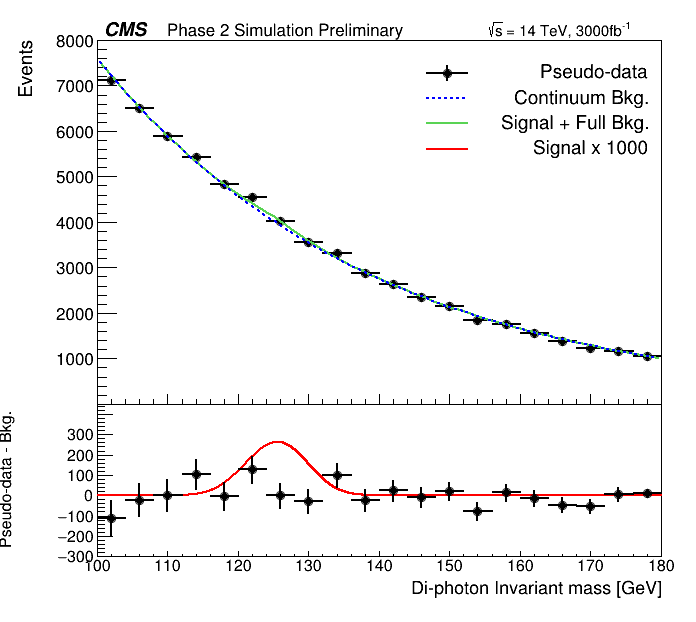

In [25]:
# Add CMS label
text = ROOT.TLatex()
text.SetNDC()

text.SetTextFont(72)
text.SetTextSize(0.05)
text.DrawLatex(0.15, 0.91, "CMS")

text.SetTextFont(42)
text.SetTextSize(0.045)
text.DrawLatex(0.24, 0.91, "Phase 2 Simulation Preliminary")

text.SetTextSize(0.04)
text.DrawLatex(0.7, 0.91, "#sqrt{s} = 14 TeV, 3000fb^{-1}")

%jsroot off
c.Draw()

In [26]:
c.SaveAs(outputdir + filename.rstrip(".root")+"_FIT.pdf")

Info in <TCanvas::Print>: pdf file ./output/Inv_mass_gghasOneL_DNN_HL_FIT.pdf has been created
